## Kaggle Competition for House Prices: Advanced Regression Techniques

In [5]:
#import libraries


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Check the train dataset

In [6]:
#import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Missing data inspection

Text(0.5, 1.0, 'TEST')

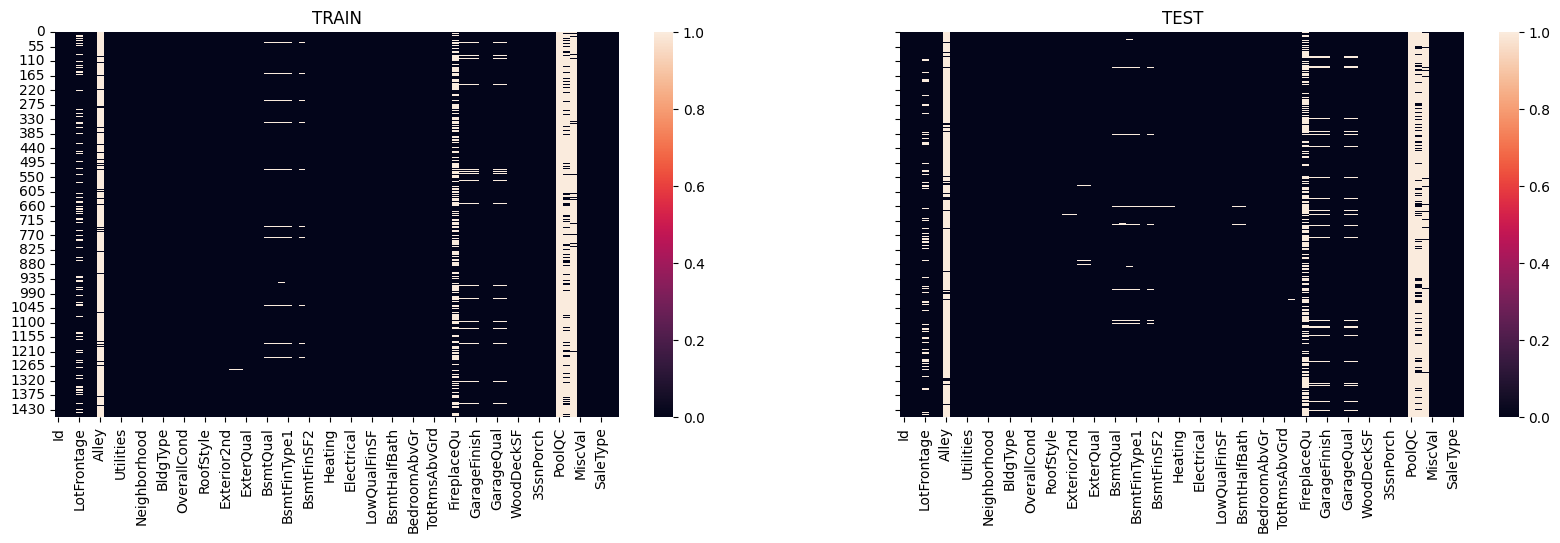

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.heatmap(train.isnull(), ax=axes[0])
axes[0].set_title('TRAIN')

sns.heatmap(test.isnull(), ax=axes[1])
axes[1].set_title('TEST')

### Data preparation
##### N/A data cleaning

In [11]:
train.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Ut

In [30]:
#fill missing values
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())
train.drop(['Alley'], axis=1, inplace=True)
train['BsmtCond'] = 
def NullHandling(feature):
    if train[feature].isnull().sum() + test[feature].isnull().sum() == 0:
        pass
    else :
        if (train[feature].isnull().sum())/(train.size[0]) > 0.75 or (test[feature].isnull().sum())/(train.size[0]) > 0.75:
                train.drop([feature], axis=1, inplace=True)
                test.drop([feature], axis=1, inplace=True)
        else:
            if str(train[feature].squeeze().dtype) == 'object':
                train[feature] = train[feature].fillna(train[feature].mode()[0])
                 


